In [1]:
import tensorflow as tf
from tensorflow import keras


import generator_model
import generator_model2
import generator_model3
import generator_model4
import discriminator_model
import discriminator_model2
import GAN_model2
import generator_pretrain
import generator_pretrain_cycle
import Callbacks

In [2]:
import math
import pickle
import glob
from pathlib import Path

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from AnnotationData import AnnotationData
%load_ext autoreload
%autoreload 2

In [4]:
folder = "D:/FER/IstrazivackiSeminar"
backgrounds_path = "D:/FER/IstrazivackiSeminar/empty_labels/"
batch_size = 32
image_size = (128,128)

In [5]:
def loadAnnotation(input_folder):
    data = []
    paths = glob.glob(input_folder + "/**/*.pkl", recursive=True)
    for path in paths:
        with open(path, "rb") as file:
            annotations = pickle.load(file)
        annotationsArray = [(str(Path(path).parent) + "\\" + name, ant) for (name, ant) in annotations]
        data += annotationsArray
    return data

In [6]:
annotation = loadAnnotation(folder)

In [7]:
class GAN_Dataset(keras.utils.Sequence):
    def __init__(self, data, batch_size, image_size, backgrounds_path):
        self.image_size = image_size
        self.data = data
        self.batch_size = batch_size
        self.backgrounds_path = backgrounds_path
        self.bacgrounds = np.array([self.loadImage(path) for path in glob.glob(self.backgrounds_path +"/*")])

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size) - 1

    def __getitem__(self, idx):
        images = np.array([self.loadImage(name) for (name, ant) in self.data[idx * self.batch_size: (idx + 1) * self.batch_size]])
        annotation = np.array([np.expand_dims(ant.astype(np.float32), -1) for (name, ant) in self.data[idx * self.batch_size: (idx + 1) * self.batch_size]])
        bg_indices = np.random.choice(self.bacgrounds.shape[0], images.shape[0])
        bg = self.bacgrounds[bg_indices]
        return images, annotation, bg
            
    def loadImage(self, path):
        img = Image.open(path).resize(self.image_size)
        img = np.array(img, dtype=np.float32) / 255
        return np.expand_dims(img, -1)
 

In [8]:
dataset = GAN_Dataset(annotation, batch_size, image_size, backgrounds_path)

In [50]:
annotation[0]

('D:\\FER\\IstrazivackiSeminar\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png',
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8))

In [58]:
import cv2
import numpy as np

# Load the two images
image1 = cv2.imread('D:\\FER\\IstrazivackiSeminar\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png', 0)
image2 = cv2.imread('D:\\FER\\IstrazivackiSeminar\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png', 0)

# Initialize the feature detector (SIFT)
detector = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = detector.detectAndCompute(image1, None)
keypoints2, descriptors2 = detector.detectAndCompute(image2, None)

# Initialize the feature matcher (Brute-Force)
matcher = cv2.BFMatcher(cv2.NORM_L2)

# Match the keypoints
matches = matcher.match(descriptors1, descriptors2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Select top N matches
top_matches = matches[:1]

# Extract matching keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in top_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in top_matches]).reshape(-1, 1, 2)

# Estimate affine transformation
M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

# Apply the estimated transformation to image2
aligned_image2 = cv2.warpAffine(image2, M, (image1.shape[1], image1.shape[0]))

# Calculate SSIM on aligned images
ssim_score = tf.image.ssim_multiscale(image1, aligned_image2, max_val=1, filter_size=8)

print("SSIM Score:", ssim_score)


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2604: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'cv::warpAffine'


In [ ]:
np.array(

In [19]:
tf.image.ssim_multiscale(dataset[0][0],dataset[1][0], max_val=1.0,filter_size=8)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.500307  , 0.53416896, 0.76899225, 0.6757343 , 0.43299267,
       0.45505008, 0.6612791 , 0.3156949 , 0.37384903, 0.2842308 ,
       0.43710488, 0.4089178 , 0.52524114, 0.5763759 , 0.62381136,
       0.6855148 , 0.4886498 , 0.31788325, 0.6813276 , 0.63287574,
       0.4690348 , 0.700062  , 0.41172945, 0.44161087, 0.64697623,
       0.3586871 , 0.4830075 , 0.1856217 , 0.37194374, 0.35507786,
       0.5306537 , 0.44508526], dtype=float32)>

In [9]:
len(dataset)

54

In [22]:
dataset[54][0].shape

(0,)

In [9]:
generator = generator_model3.model(image_size, 1,1, channels=[16, 16, 32, 64, 128, 128], concat_channels=[64, 64, 64, 7]
)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 10, 10, 2)    0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 64)   6336        concatenate[0][0]        

In [36]:
discriminator = discriminator_model2.model(image_size, 1, channels=[64,128,256,64,128,128,64], up_channels=[32, 32, 7])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_transpose_8 (Conv2DTrans (None, 16, 16, 32)   1600        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_9 (Conv2DTrans (None, 64, 64, 32)   9248        conv2d_transpose_8[0][0]         
__________________________________________________________________________________________________
conv2d_transpose_10 (Conv2DTran (None, 128, 128, 7)  2023        conv2d_transpose_9[0][0]         
______________________________________________________________________________________

In [10]:
showCallbacks = Callbacks.ShowGeneratedImages(dataset)

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

vgg = VGG16(include_top=False, weights='imagenet')
vgg.trainable = False
selected_layers = ['block3_conv3', 'block4_conv3']
outputs = [vgg.get_layer(layer).output for layer in selected_layers]
feature_extractor = Model(inputs=vgg.input, outputs=outputs)

@tf.function
def perceptual_loss(y_true, y_pred):
    
    true_features = feature_extractor(tf.concat([y_true, y_true, y_true], axis = -1))
    pred_features = feature_extractor(tf.concat([y_pred, y_pred, y_pred], axis = -1))
    loss = 0.0
    for true_feature, pred_feature in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.square(true_feature - pred_feature))
    return loss

In [31]:
perceptual_loss(dataset[0][0],dataset[0][0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [16]:
perceptual_loss

<tf.Tensor: shape=(), dtype=float32, numpy=24.490017>

In [16]:
def identity_loss(true, preds):
    ssim_m = tf.image.ssim_multiscale(true,preds, max_val=1.0,filter_size=8)
    return 1 - tf.reduce_mean(ssim_m)

In [32]:
pretrain = generator_pretrain.GAN_model(
    generator=generator, batch_size = batch_size, label_size = (10,10)
)
pretrain.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=perceptual_loss
    
)


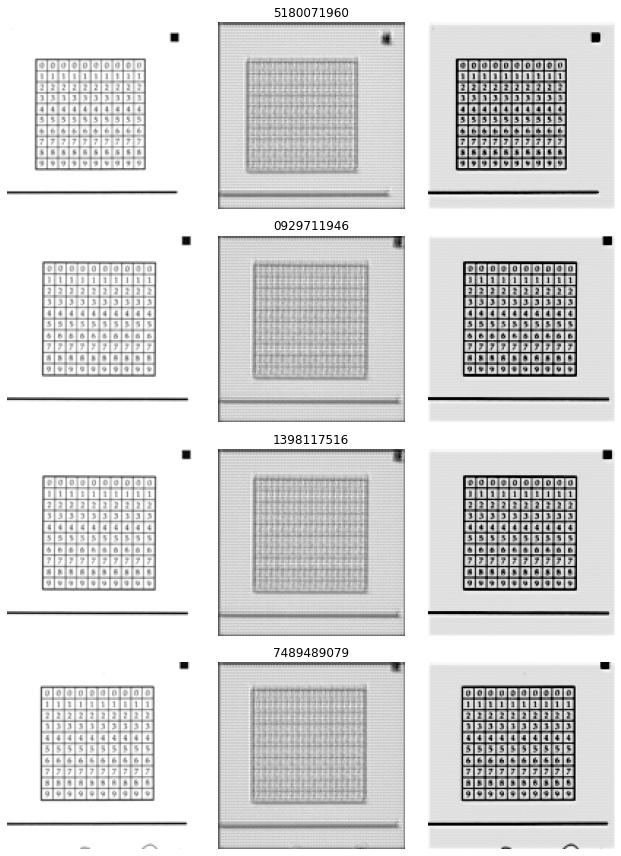

Epoch 1/10
112/112 [==============================] - 63s 439ms/step - loss: 34.6337


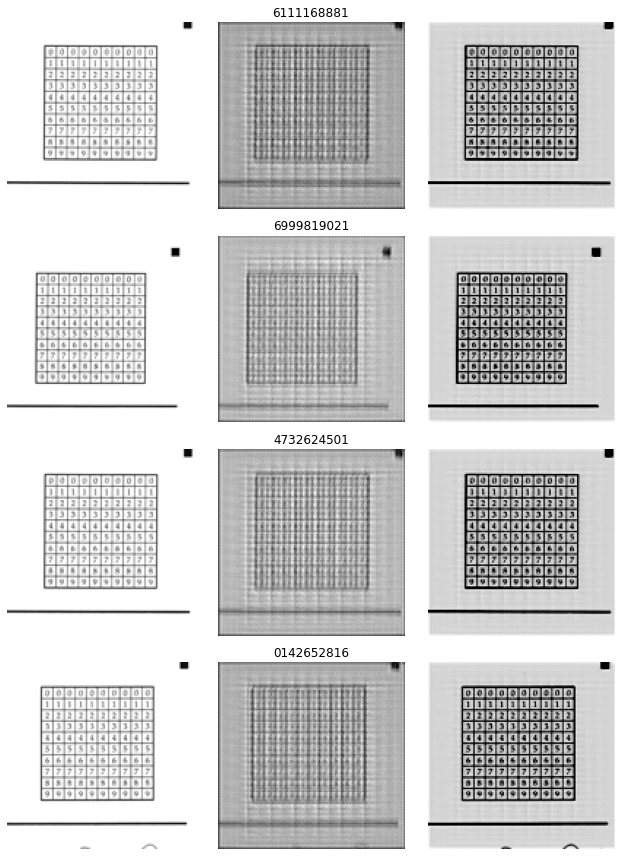

Epoch 2/10
112/112 [==============================] - 47s 414ms/step - loss: 32.6564


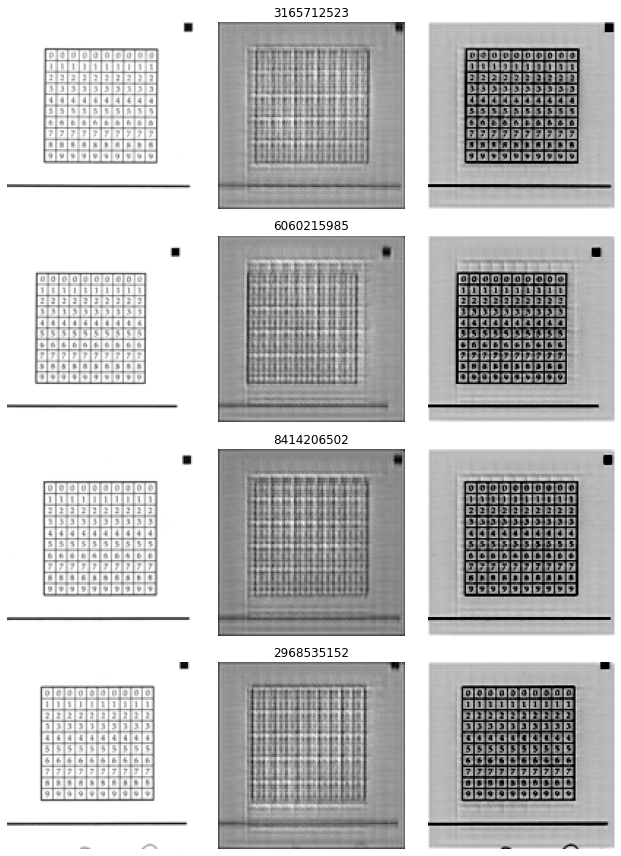

Epoch 3/10
112/112 [==============================] - 47s 414ms/step - loss: 31.5656


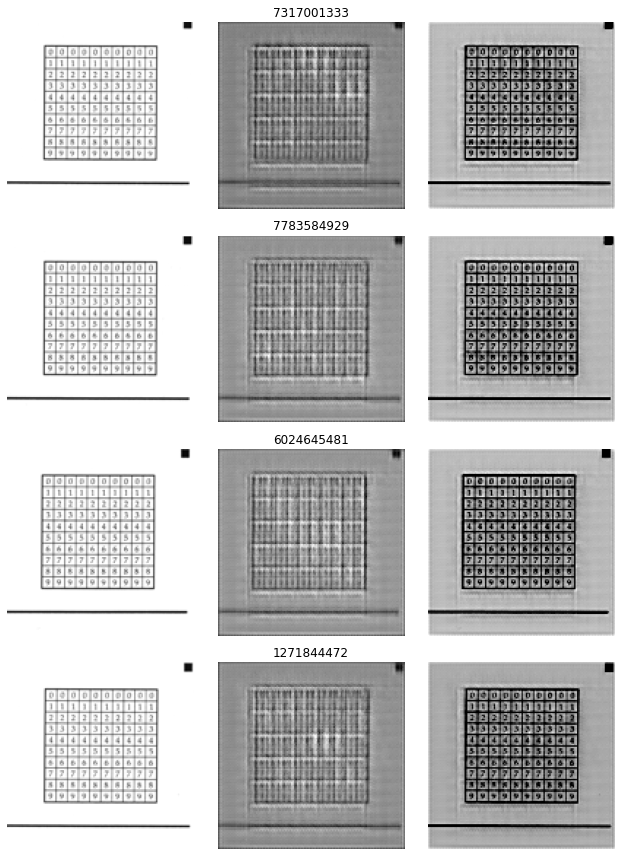

Epoch 4/10
112/112 [==============================] - 45s 404ms/step - loss: 30.7640


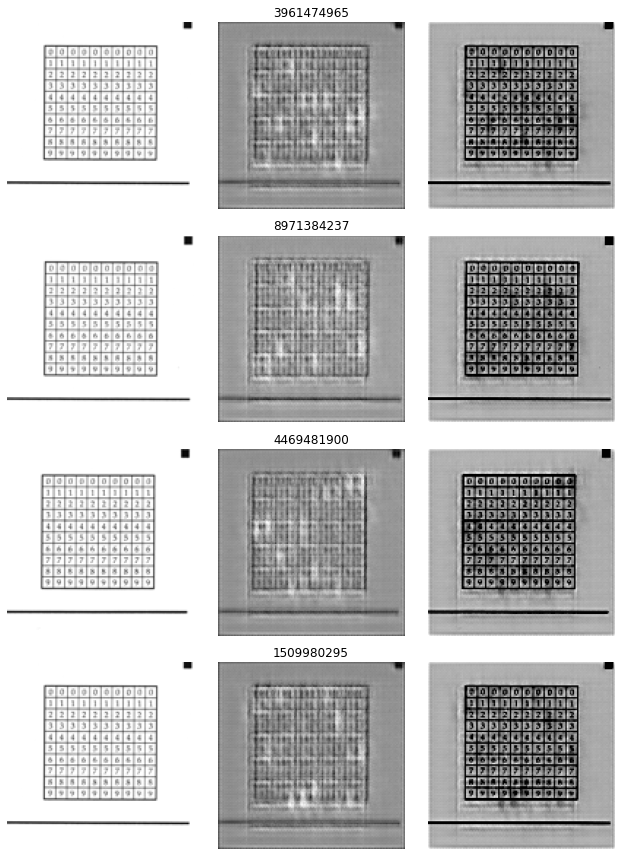

Epoch 5/10
112/112 [==============================] - 47s 417ms/step - loss: 29.4552


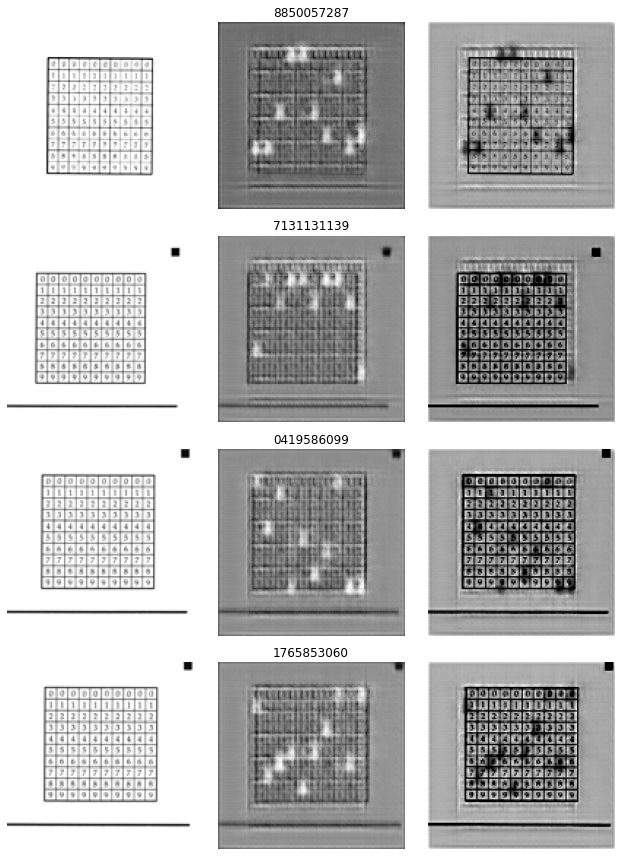

Epoch 6/10
112/112 [==============================] - 47s 416ms/step - loss: 28.9026


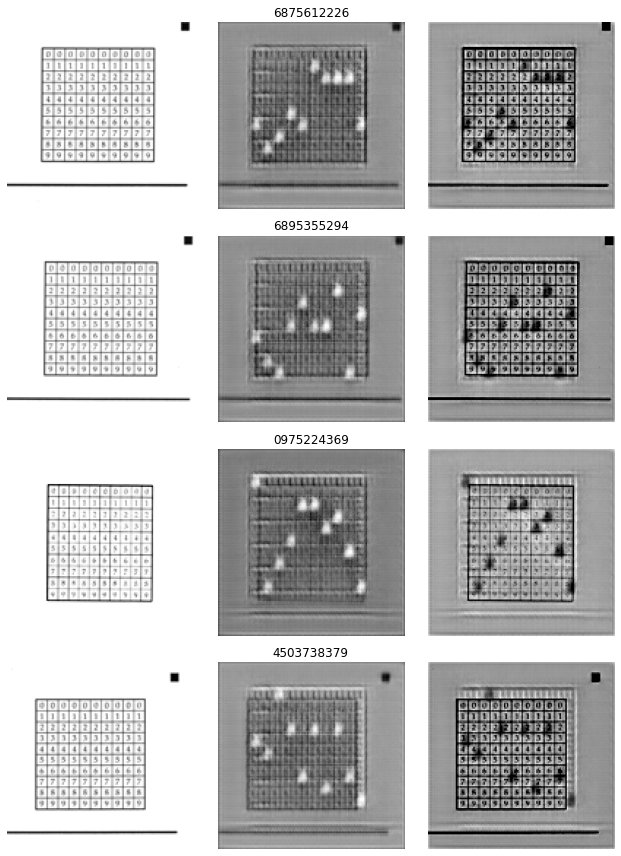

Epoch 7/10
112/112 [==============================] - 45s 401ms/step - loss: 28.6059


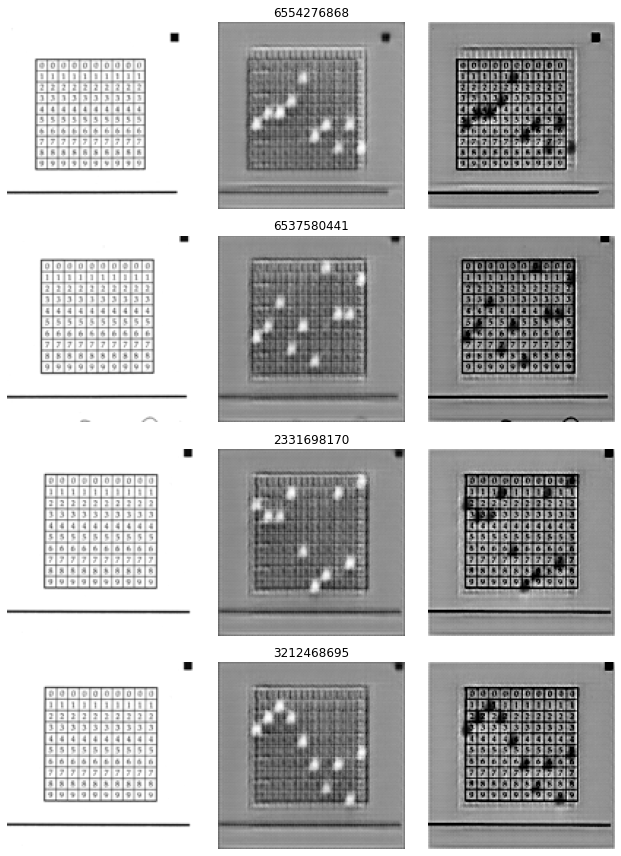

Epoch 8/10
112/112 [==============================] - 46s 409ms/step - loss: 28.0983


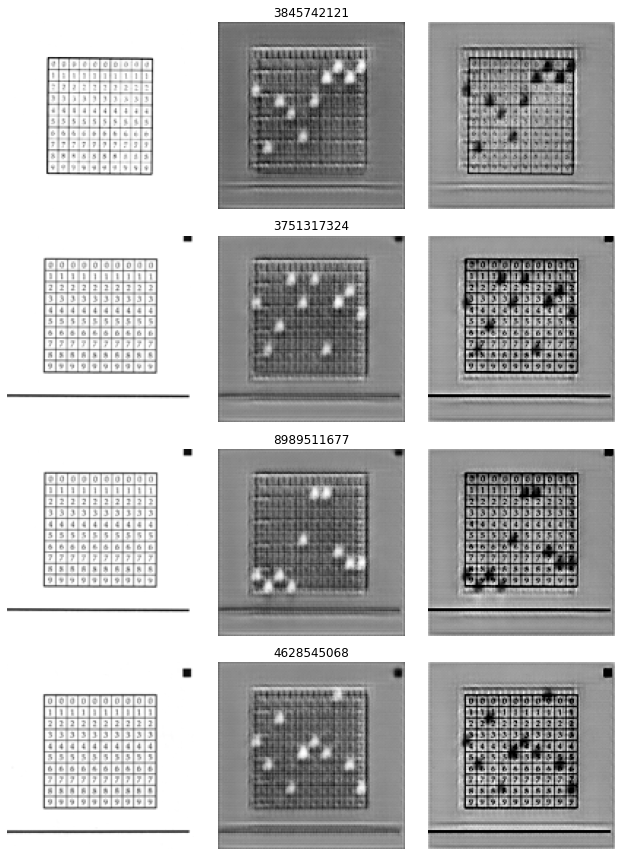

Epoch 9/10
112/112 [==============================] - 47s 414ms/step - loss: 27.7306


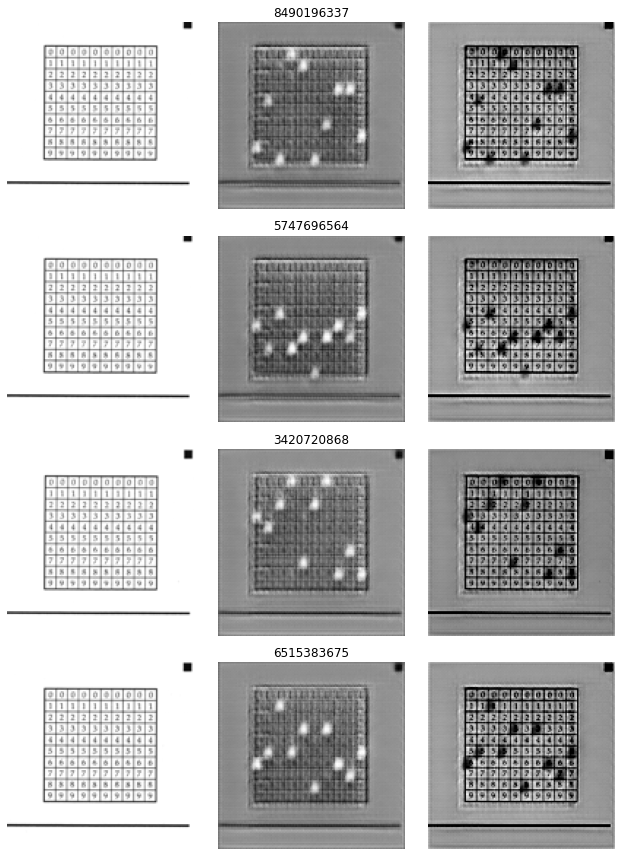

Epoch 10/10
112/112 [==============================] - 46s 406ms/step - loss: 27.5995


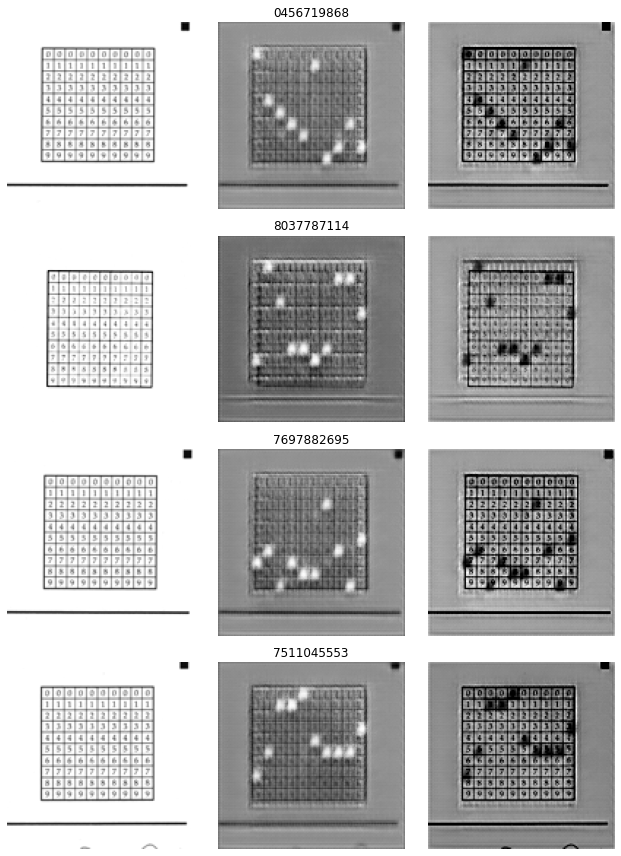

In [34]:
pretrain.fit(dataset, epochs=10, callbacks=[showCallbacks])

In [44]:
cond_gan = GAN_model2.GAN_model(
    discriminator=discriminator, generator=generator, batch_size = batch_size, label_size = (10,10), num_gen_per_dis=3, alfa = 0.02, dicriminator_ouput=(8,8)
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001,clipvalue=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001,clipvalue=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
    identity_loss=perceptual_loss
    
)



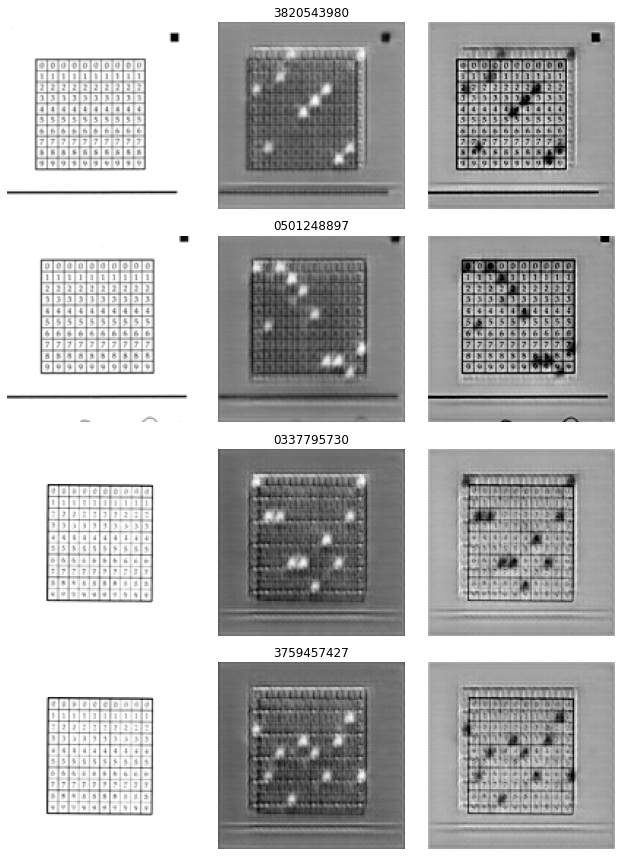

Epoch 1/100
112/112 [==============================] - 228s 2s/step - d_loss: 0.6403 - g_d_loss: 0.6382 - g_id_loss: 0.6379 - g_grad_norm: 0.9194 - g_grad_max: 0.1468


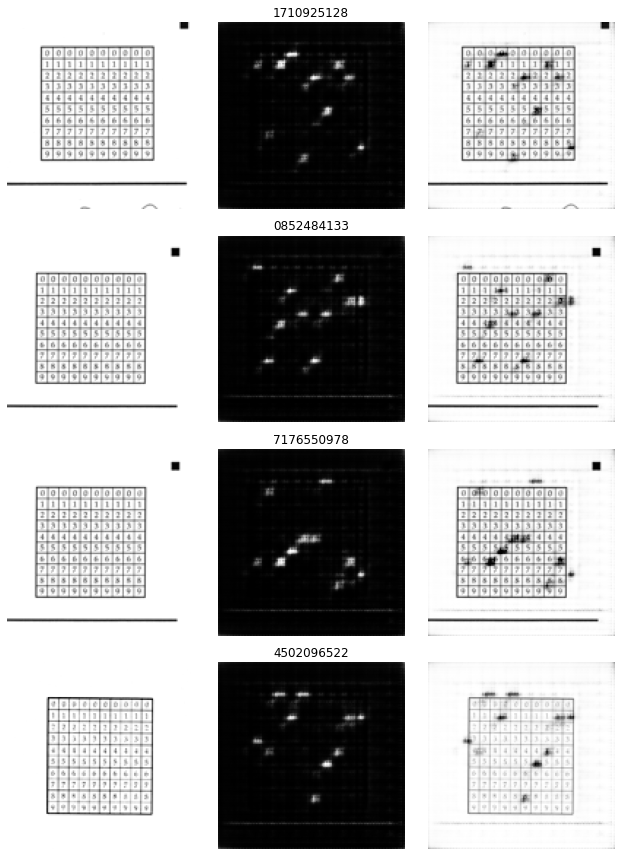

Epoch 2/100
112/112 [==============================] - 212s 2s/step - d_loss: 0.6795 - g_d_loss: 0.7178 - g_id_loss: 0.6594 - g_grad_norm: 0.7930 - g_grad_max: 0.1062


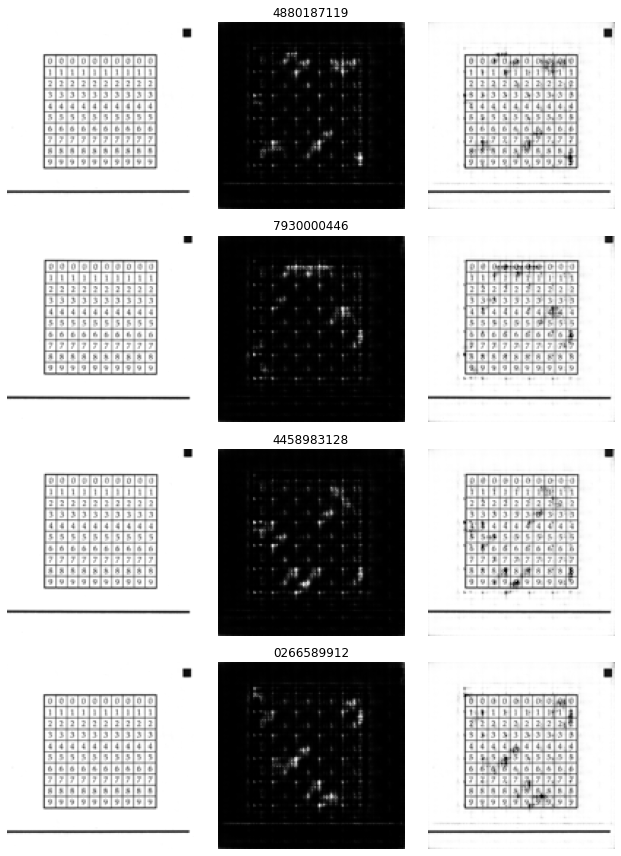

Epoch 3/100
112/112 [==============================] - 216s 2s/step - d_loss: 0.6495 - g_d_loss: 0.8273 - g_id_loss: 0.6565 - g_grad_norm: 0.7952 - g_grad_max: 0.1064


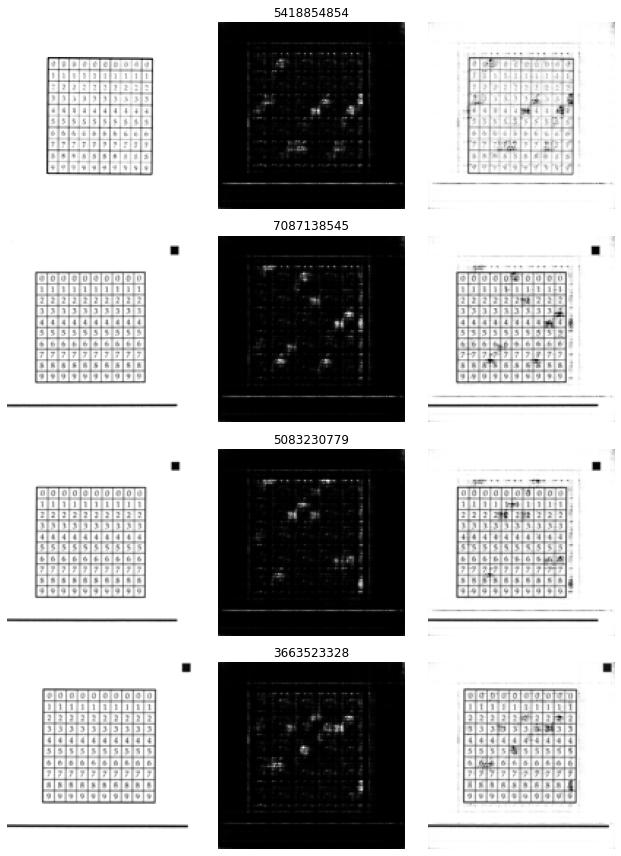

Epoch 4/100
112/112 [==============================] - 215s 2s/step - d_loss: 0.6380 - g_d_loss: 0.8559 - g_id_loss: 0.6226 - g_grad_norm: 0.8273 - g_grad_max: 0.1131


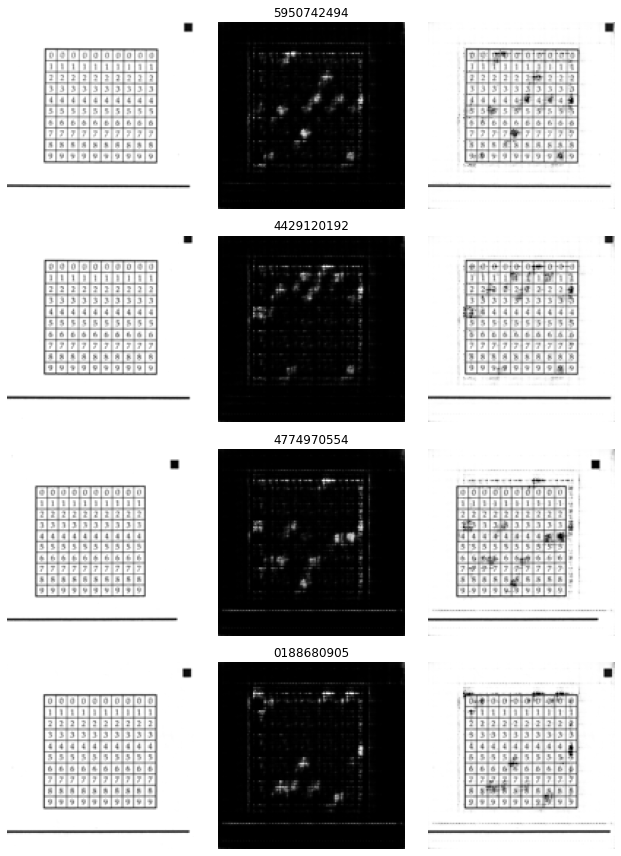

Epoch 5/100
112/112 [==============================] - 215s 2s/step - d_loss: 0.6174 - g_d_loss: 0.9288 - g_id_loss: 0.6371 - g_grad_norm: 0.7747 - g_grad_max: 0.1253


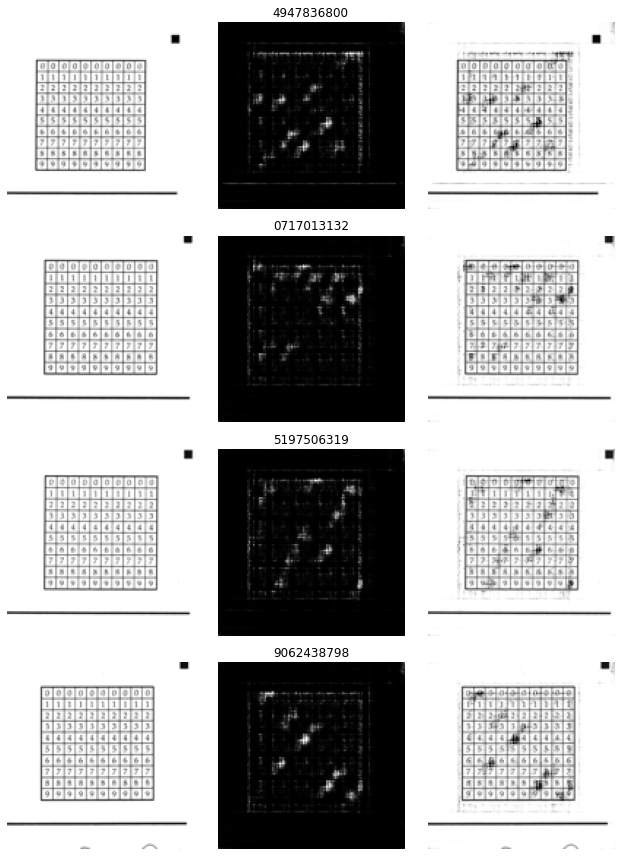

Epoch 6/100
 77/112 [===================>..........] - ETA: 1:07 - d_loss: 0.5935 - g_d_loss: 1.0203 - g_id_loss: 0.6360 - g_grad_norm: 0.7952 - g_grad_max: 0.1310

KeyboardInterrupt: 

In [46]:
cond_gan.fit(dataset, epochs=100, callbacks=[showCallbacks])